# Reference mapping to annotate IN subclusters

Script to label transfer IN subclusters defined from the initial screen to targeted screens

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
#from scar import setup_anndata
import warnings
import anndata
import numpy as np
import os
#import bbknn
warnings.simplefilter("ignore")

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
Global seed set to 94705


In [1]:
import scanpy as sc
adata_query = sc.read('/wynton/group/pollen/jding/brainchromatin/Li/HM2D_IN_query.h5ad')
adata_query.raw = adata_query.copy()
adata_query.var_names_make_unique()
print(adata_query.var_names)

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A2MP1', 'A3GALT2',
       ...
       'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'hsa-mir-1253', 'hsa-mir-423'],
      dtype='object', length=38593)


## 2D data as reference

### Preprocessing/Subsetting original data

In [53]:
adata_ref = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/D7-filtered_guides.IN.h5ad')

In [54]:
adata_ref

AnnData object with n_obs × n_vars = 17333 × 38593
    obs: 'batch_name', 'GRCh38', 'rheMac10', 'call', 'species', 'individual-Q', 'individual', 'sgRNA_NKS', 'num_guide_IDs', 'log', 'clone_barcode', 'clone_barcode_criteria', 'batch', 'percent_ribo', 'percent_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'gene_NKS', 'num_gene_NKS', 'sgRNA', 'num_sgRNA', 'sgRNA_effecitve', 'timepoint', 'stage', 'sample_id', 'sex', 'species_batch', 'Ident', '_scvi_batch', '_scvi_labels', 'labels_scanvi', 'leiden', 'leiden-.2', 'leiden-.3', 'leiden-.8', 'predictions', 'timepoint_batch_name', 'class', 'leiden-.4', 'supervised_name', 'subtype'
    var: 'gene_ids-HD0', 'feature_types-HD0', 'genome-HD0', 'mt-HD0', 'n_cells_by_counts-HD0', 'mean_counts-HD0', 'pct_dropout_by_counts-HD0', 'total_counts-HD0', 'gene_ids-HD7', 'feature_types-HD7', 'genome-HD7', 'mt-HD7', 'n_cells_by_counts-HD7', 'mean_counts-HD7', 'pct_dropout_by_counts-HD7', 'total_counts-HD7', 'gene_ids

In [55]:
adata_ref.layers["counts"] = adata_ref.X.copy()
adata_ref.raw = adata_ref

In [56]:
sc.pp.normalize_total(adata_ref,exclude_highly_expressed=True)
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(adata_ref, n_top_genes=2500, batch_key="Ident", subset= True)
#adata_ref.var['highly_variable']=[x for x in adata_ref.var['highly_variable'] if x in adata_query.var_names]

/wynton/home/pollenlab/jding/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/wynton/home/pollenlab/jding/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/wynton/home/pollenlab/jding/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:485: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


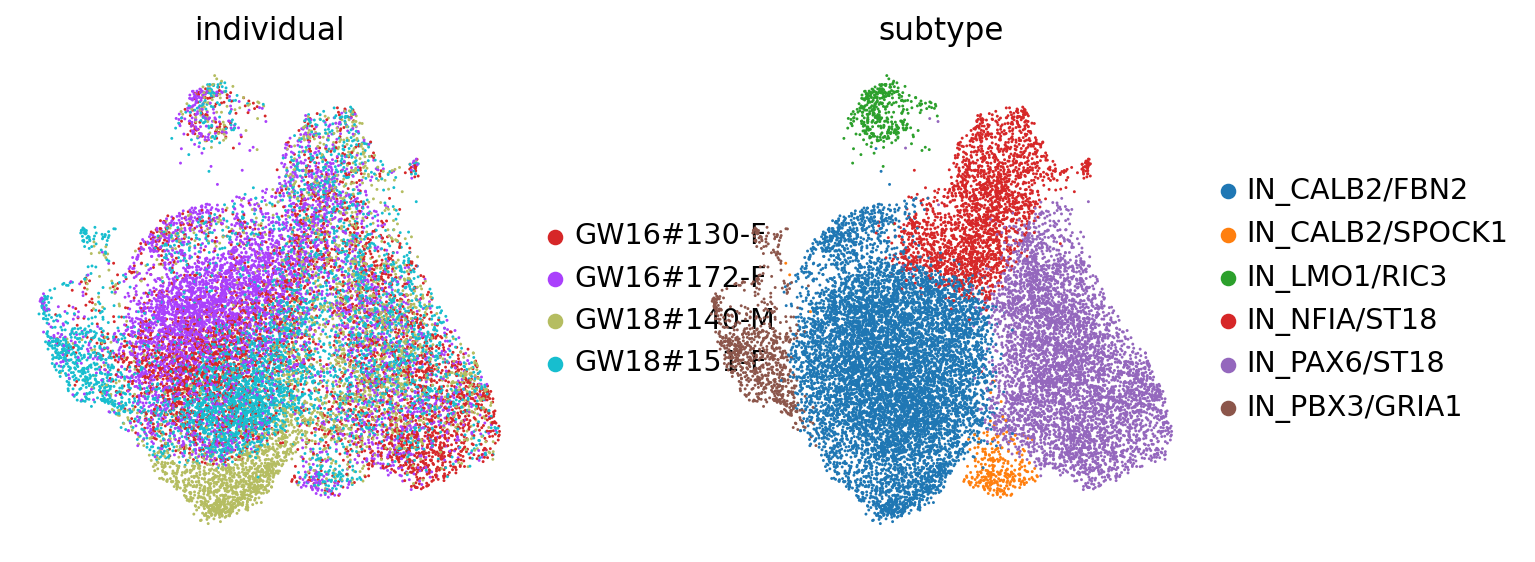

In [ ]:
sc.pl.umap(
    adata_ref,
    color=[ "individual",'subtype'],
    frameon=False,
)

In [61]:
adata_ref.obs['subtype'].value_counts()

IN_CALB2/FBN2      8726
IN_PAX6/ST18       4819
IN_NFIA/ST18       2275
IN_PBX3/GRIA1       839
IN_LMO1/RIC3        381
IN_CALB2/SPOCK1     293
Name: subtype, dtype: int64

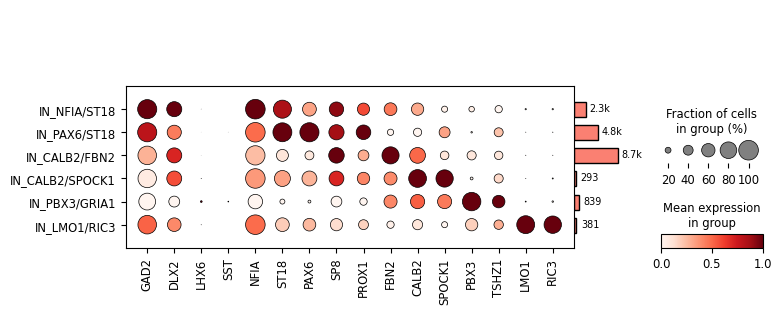

In [82]:
adata_ref.obs['subtype'] = adata_ref.obs['subtype'].astype('category')
dp = sc.pl.dotplot(adata_ref, ['GAD2','DLX2','LHX6','SST','NFIA','ST18',
                          'PAX6','SP8','PROX1','FBN2','CALB2','SPOCK1','PBX3','TSHZ1','LMO1','RIC3'], 
                   'subtype', cmap='Reds' ,
                   categories_order = ['IN_NFIA/ST18','IN_PAX6/ST18','IN_CALB2/FBN2','IN_CALB2/SPOCK1','IN_PBX3/GRIA1','IN_LMO1/RIC3'],
                                 standard_scale='var',dot_max=0.6, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap='Reds').savefig("./figures/dotplot-IN.pdf")

categories: IN_CALB2/FBN2, IN_CALB2/SPOCK1, IN_LMO1/RIC3, etc.
var_group_labels: panIN, CGE, MGE, etc.


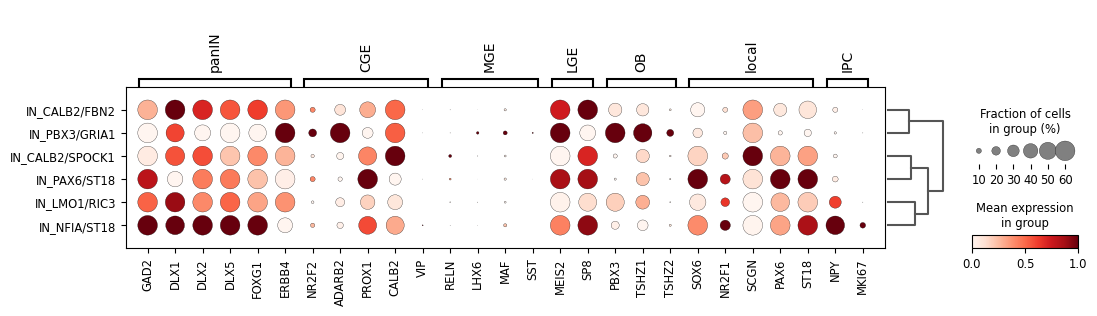

In [47]:
marker_genes_dict = {
    "panIN": ['GAD2','DLX1','DLX2','DLX5','FOXG1','ERBB4',],
    "CGE": ['NR2F2','ADARB2','PROX1','CALB2','VIP'],
    "MGE": ['RELN','LHX6','MAF','SST'],
    "LGE": ['MEIS2','SP8'],
    "OB": ['PBX3','TSHZ1','TSHZ2'],
    "local": ['SOX6','NR2F1','SCGN','PAX6','ST18'],
    "IPC": ['NPY','MKI67'],
}
sc.pl.dotplot(adata_ref, marker_genes_dict, 'subtype', dendrogram=True, cmap='Reds' ,
                                 standard_scale='var',dot_max=0.6)

### Import query data

In [ ]:
#subset data for 2D IN lineage
import scanpy as sc 
adata_query = sc.read('/wynton/group/pollen/jding/brainchromatin/Li/query_HM2Dall_guides.h5ad')
adata_query = adata_query[adata_query.obs['batch'].isin(['HMD7','HM2ndD7'])]
adata_query = adata_query[adata_query.obs['supervised_name'].isin(['IN_dLGE/CGE'])]

In [ ]:
#adata_query = adata_query[adata_query.obs['species'] =='macaque']

In [ ]:
adata_query.raw = adata_query.copy()
adata_query.layers['counts'] = adata_query.X

In [ ]:
adata_ref.var_names_make_unique()
adata_query.var_names_make_unique()

In [ ]:
sc.pp.normalize_total(adata_query, target_sum=1e4,exclude_highly_expressed=True)
sc.pp.log1p(adata_query)
sc.pp.highly_variable_genes(adata_query, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_query, max_value=10)
sc.pp.highly_variable_genes(adata_query, n_top_genes=2500, batch_key="batch_name", subset= False)

In [ ]:
var = [x for x in adata_ref.var_names if x in adata_query.var_names]
adata_ref = adata_ref[:, var].copy()
adata_query = adata_query[:, var].copy()

In [ ]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="individual", layer="counts")

arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_ref,
    **arches_params
)
vae_ref.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████| 400/400 [52:03<00:00,  7.74s/it, loss=768, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [52:03<00:00,  7.81s/it, loss=768, v_num=1]


In [ ]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

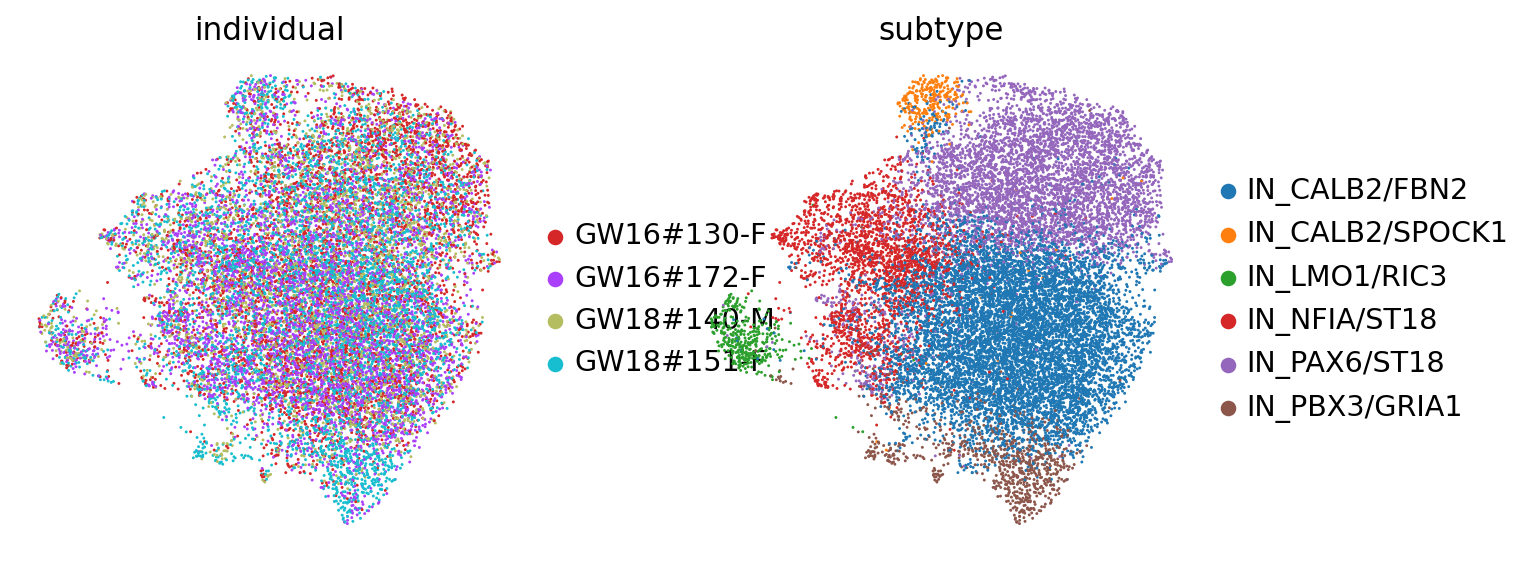

In [ ]:
sc.pl.umap(
    adata_ref,
    color=[ "individual",'subtype'],
    frameon=False,
)

In [18]:
# save the reference model
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path = os.path.join(directory,'scVI_model_IN/')
vae_ref.save(dir_path, overwrite=True)

In [20]:
# load the reference model
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path = os.path.join(directory,'scVI_model_IN/')
vae_ref = scvi.model.SCVI.load(dir_path,adata_ref)

INFO     File /wynton/group/pollen/jding/brainchromatin/Li/scVI_vivo_model_HM2D/model.pt already downloaded        


In [19]:
# both are valid
scvi.model.SCVI.prepare_query_anndata(adata_query, dir_path)
#scvi.model.SCVI.prepare_query_anndata(adata_query, vae_ref)

INFO     File /wynton/scratch/jding/brainchromatin/Li/scVI_model_IN/model.pt already downloaded                    
INFO     Found 100.0% reference vars in query data.                                                                


In [20]:
adata_query.obs['Ident'] = adata_query.obs['batch_name']

In [21]:
# both are valid
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    dir_path,
)
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    vae_ref,
)

INFO     File /wynton/scratch/jding/brainchromatin/Li/scVI_model_IN/model.pt already downloaded                    


In [22]:
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|███████| 200/200 [22:10<00:00,  6.87s/it, loss=593, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████| 200/200 [22:10<00:00,  6.65s/it, loss=593, v_num=1]


In [23]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

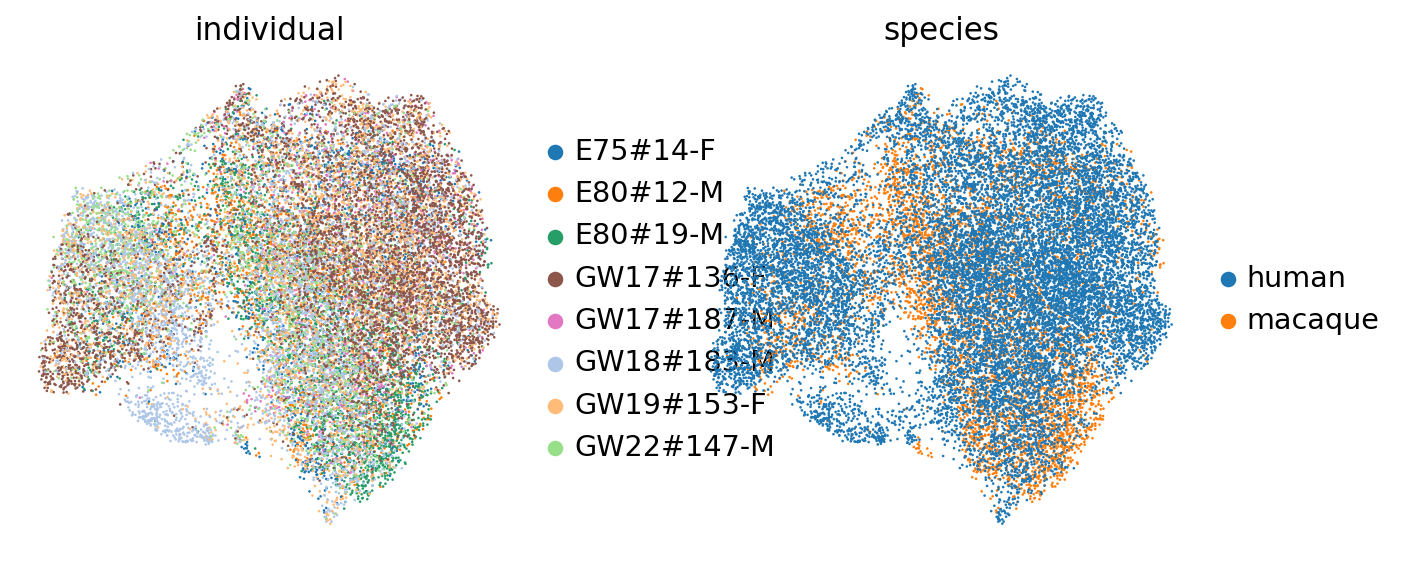

In [24]:
sc.pl.umap(
    adata_query,
    color=[ "individual",'species'],
    frameon=False,
)

In [ ]:
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
adata_ref.write(os.path.join(directory,'ref.h5ad'), compression='gzip')

### Reference mapping from 2D with SCANVI

In [25]:
adata_ref.obs["labels_scanvi"] = adata_ref.obs["subtype"].values

In [26]:
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path = os.path.join(directory,'scVI_model_IN/')
vae_ref = scvi.model.SCVI.load(dir_path, adata_ref)

INFO     File /wynton/scratch/jding/brainchromatin/Li/scVI_model_IN/model.pt already downloaded                    


In [27]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

In [28]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|███████████| 20/20 [03:10<00:00,  9.41s/it, loss=806, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [03:10<00:00,  9.55s/it, loss=806, v_num=1]


In [29]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

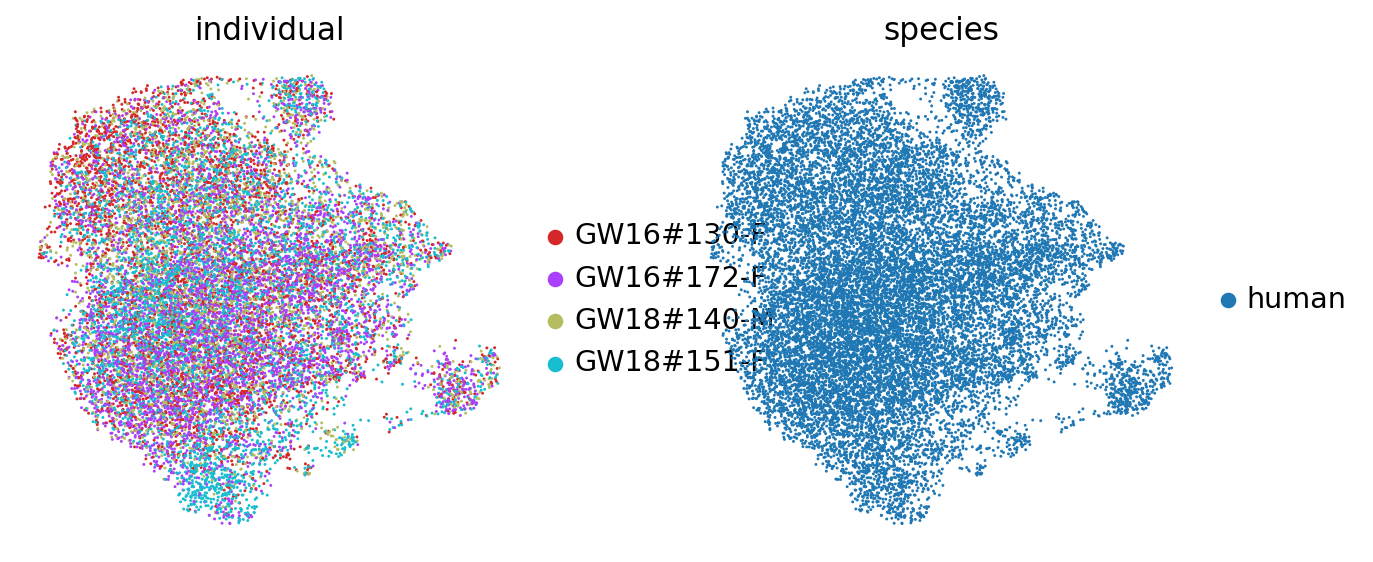

In [30]:
sc.pl.umap(
    adata_ref,
    color=[ "individual",'species'],
    frameon=False,
)

In [31]:
# save the reference model
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path_scan = os.path.join(directory,'scanvi_model_IN/')
vae_ref_scan.save(dir_path_scan, overwrite=True)

In [36]:
# load the reference model
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path_scan = os.path.join(directory,'scanvi_model_IN/')
vae_ref_scan = scvi.model.SCANVI.load(dir_path_scan,adata_ref)

INFO     File /wynton/group/pollen/jding/brainchromatin/Li/scanvi_vivo_model_HM2D/model.pt already downloaded      


In [32]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File /wynton/scratch/jding/brainchromatin/Li/scanvi_model_IN/model.pt already downloaded                  
INFO     Found 100.0% reference vars in query data.                                                                


In [33]:
vae_q = scvi.model.SCANVI.load_query_data(adata_query,vae_ref_scan)

In [34]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|███████| 100/100 [13:19<00:00,  8.07s/it, loss=596, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [13:19<00:00,  7.99s/it, loss=596, v_num=1]


In [35]:
# save the query model
directory='/wynton/group/pollen/jding/brainchromatin/Li/'
directory='/wynton/scratch/jding/brainchromatin/Li/'
dir_path_scan = os.path.join(directory,'scanvi_model_IN_query/')
vae_q.save(dir_path_scan, overwrite=True)

In [36]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

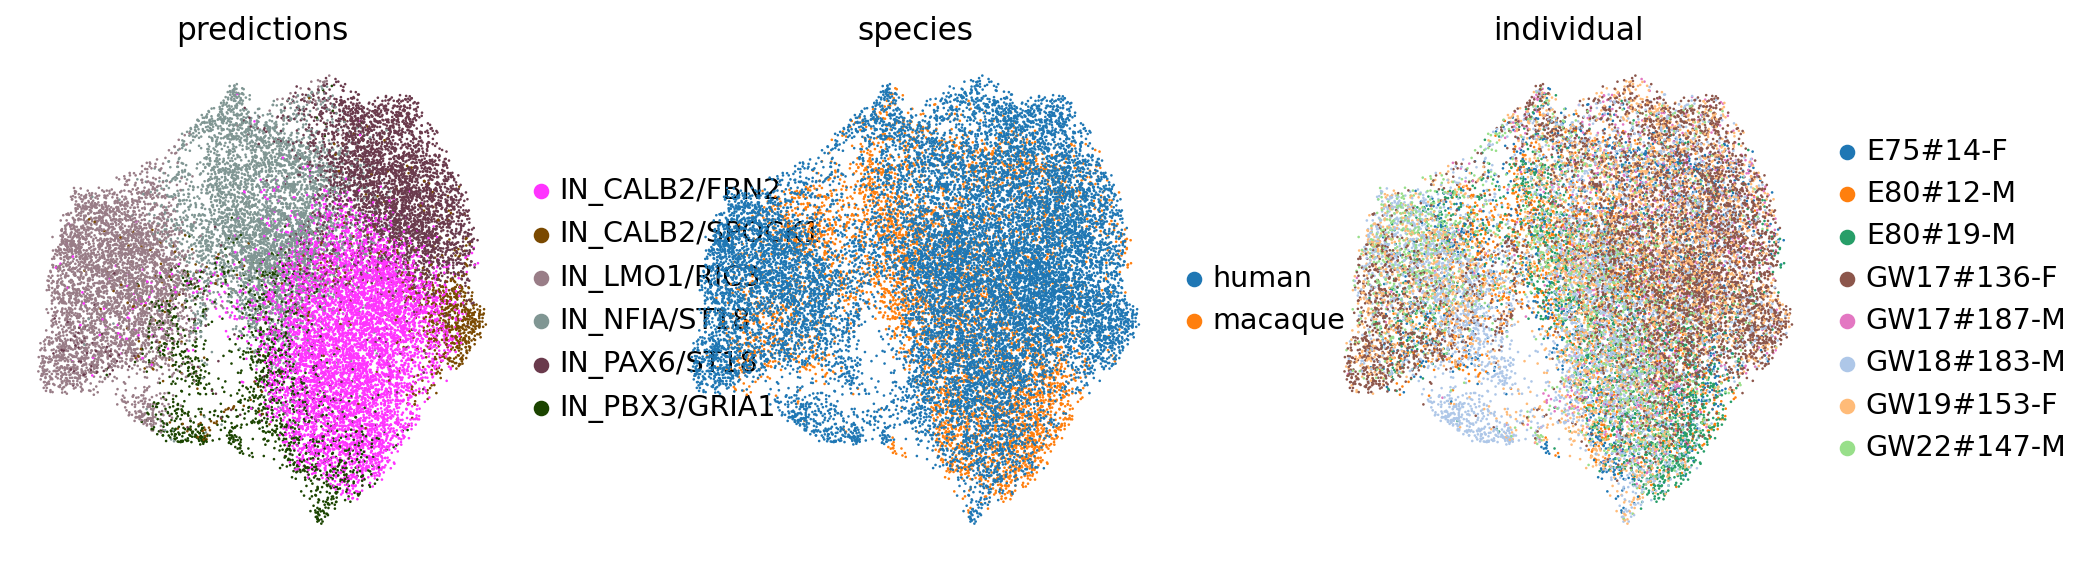

In [37]:
sc.pl.umap(adata_query,color=["predictions",'species','individual'],frameon=False,ncols=3)

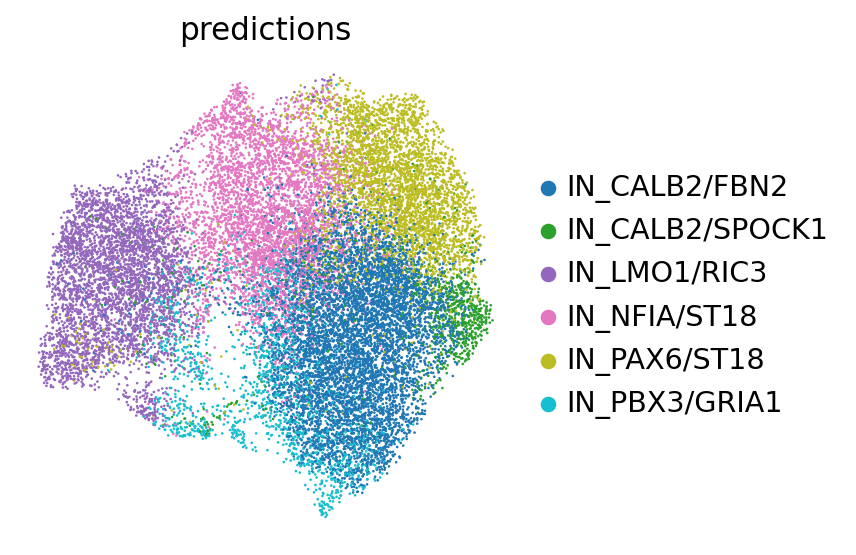

In [53]:
sc.pl.umap(adata_query,color=["predictions"],frameon=False,ncols=3)

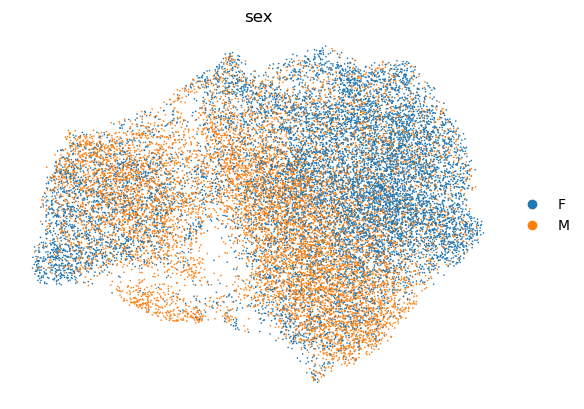

In [4]:
adata.obs['sex'] = [x.split('-')[1] for x in adata.obs['individual']]
sc.pl.umap(adata,color=["sex"],frameon=False,ncols=3)

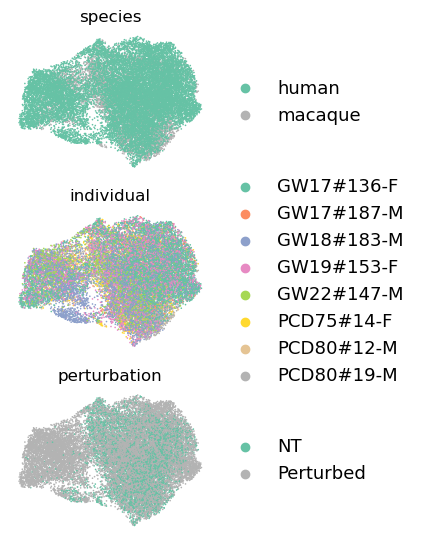

In [14]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (2, 2)
adata.obs['perturbation'] = ['NT' if x in ['WT','non-targeting'] else 'Perturbed' for x in adata.obs['gene_NKS']]
adata.obs['individual'] = adata.obs['individual'].str.replace('E', 'PCD', regex=False)
sc.pl.umap(adata, color=['species','individual','perturbation'],frameon=False, legend_fontsize=13, legend_fontoutline=3,
           palette='Set2',ncols=1,save='IN_distribution_HM2D'
          )

In [39]:
adata_query.raw.to_adata().write('/wynton/scratch/jding/brainchromatin/Li/HM2D_IN_query.h5ad')

In [70]:
import scanpy as sc
adata =  sc.read('/wynton/group/pollen/jding/brainchromatin/Li/HM2D_IN_query.h5ad')
sc.pp.normalize_total(adata,exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata,max_value=10)
sc.pp.pca(adata,n_comps=100)

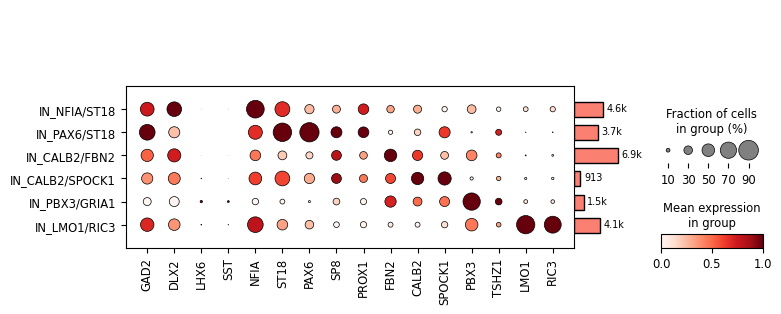

In [84]:
adata.obs['predictions'] = adata.obs['predictions'].astype('category')
dp = sc.pl.dotplot(adata, ['GAD2','DLX2','LHX6','SST','NFIA','ST18',
                          'PAX6','SP8','PROX1','FBN2','CALB2','SPOCK1','PBX3','TSHZ1','LMO1','RIC3'], 
                   'predictions', cmap='Reds' ,
                   categories_order = ['IN_NFIA/ST18','IN_PAX6/ST18','IN_CALB2/FBN2','IN_CALB2/SPOCK1','IN_PBX3/GRIA1','IN_LMO1/RIC3'],
                                 standard_scale='var',dot_max=0.6, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap='Reds').savefig("./figures/dotplot-IN-HM2D.pdf")

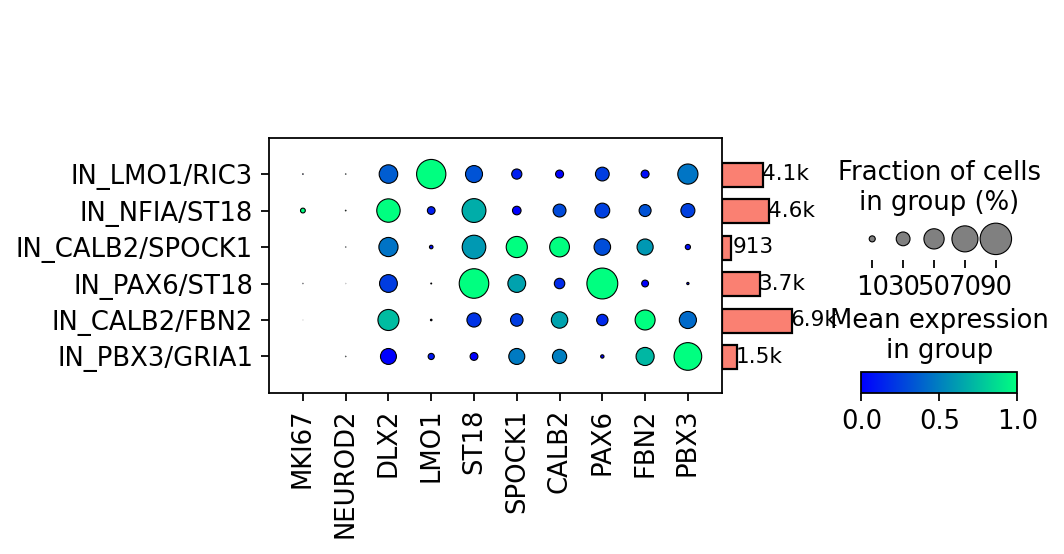

In [64]:
sc.tl.dendrogram(adata, 'predictions')
dp = sc.pl.dotplot(adata, ['MKI67','NEUROD2','DLX2','LMO1','ST18','SPOCK1','CALB2','PAX6','FBN2','PBX3',], 
                   'predictions', dendrogram=True, cmap='Reds' ,#cmap='Spectral_r',,
                                 standard_scale='var',dot_max=0.6, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

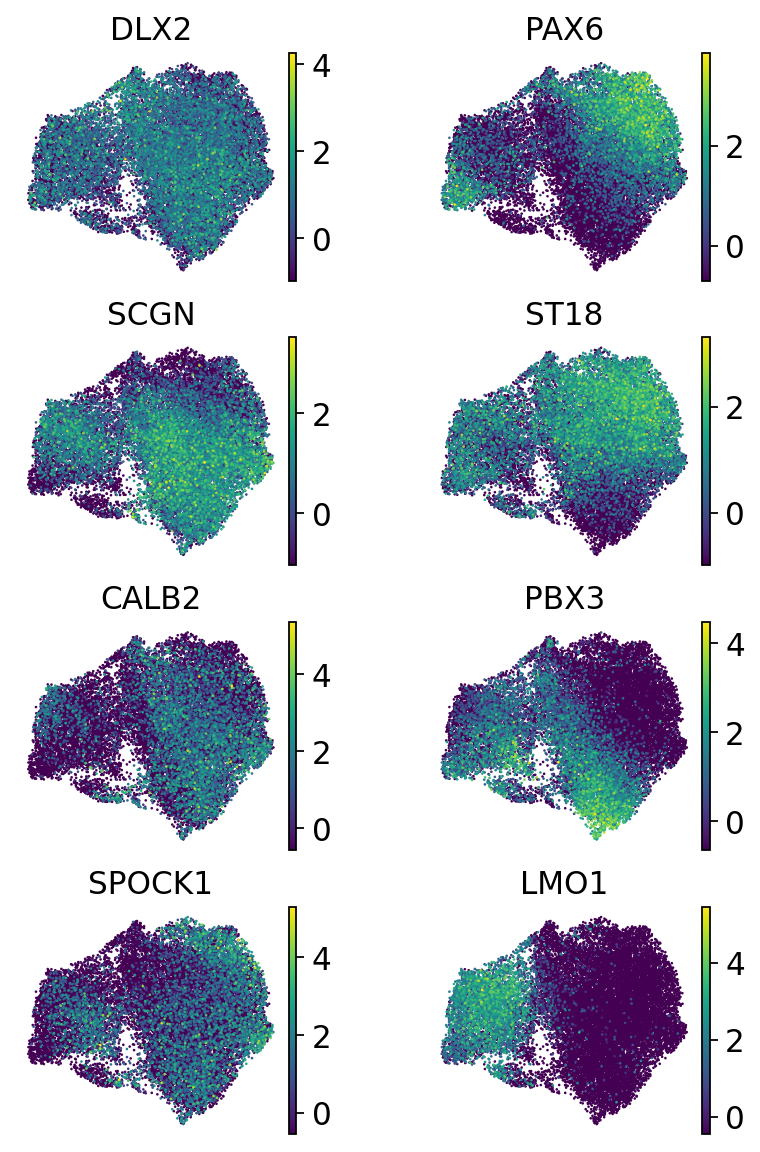

In [72]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (2, 2)
sc.pl.umap(adata, color=['DLX2','PAX6','SCGN','ST18','CALB2','PBX3','SPOCK1','LMO1'],use_raw=False,
           frameon=False, legend_fontsize=13, legend_fontoutline=3,ncols=2 ,save = 'IN_8genes_HM2D')

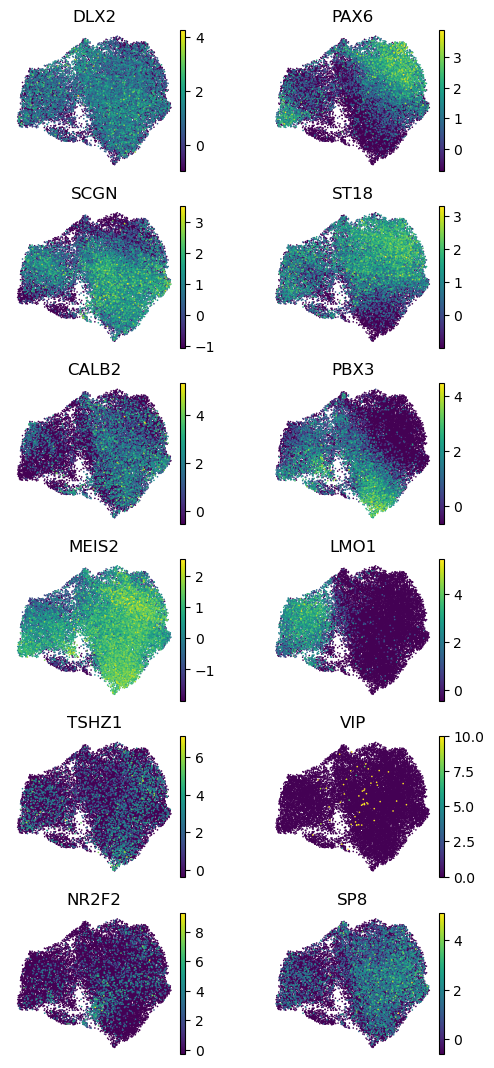

In [15]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (2, 2)
sc.pl.umap(adata, color=['DLX2','PAX6','SCGN','ST18','CALB2','PBX3',
                         'MEIS2','LMO1','TSHZ1','VIP','NR2F2','SP8'],use_raw=False,
           frameon=False, legend_fontsize=13, legend_fontoutline=3,ncols=2)